카메라 스티컵 앱 만들기

Step 1. 사진, 스티커 구하기 or 만들기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("완료")

완료


이미지 처리를 위해 opencv 와 노트북에 이미지를 출력하기 위한 matplotlib를 읽어온다.

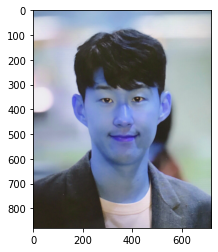

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/son.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

준비한 이미지의 색상이 이상한 것은  opencv의 특징 때문이다. 우리가 사용하게 될 matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용한다. 그런데 opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용한다. 그래서 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력된 것이다.

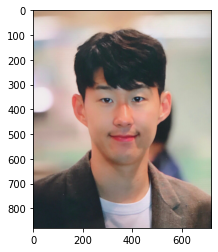

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하면 위와 같은 색깔 보정처리를 해주게 된다.

Step 2. 얼굴 검출 & 랜드마크 검출 하기

In [ ]:
# Object detection 기술을 이용해서 얼굴의 위치를 찾겠다.
# dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는다.
# HOG는 이미지에서 색상의 변화량을 나타낸 것이다. HOG를 통해 이미지로부터 물체의 특징만 잡아내는 능력을 갖출 수 있게된다.
# SVM은 선형 분류기이다. 한 이미지를 다차원 공간의 한 벡터라고 보면 여러 이미지는 여러 벡터가 된다. 이 여러 벡터를 잘 구분짓는 방법이다.
# 이미지의 색상만 가지고는 SVM이 큰 힘을 발휘하지 못한다. 하지만 이미지가 HOG를 통해 벡터로 만들어진다면 SVM이 잘 작동한다.
# 얼굴의 위치는 sliding window를 사용하여 찾는다. sliding window는 작은 영역(window)을 이동해가며 확인하는 방법을 말한다.

In [4]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
print("완료")

완료


dlib을 활용해 hog detector를 선언한다.

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("완료")

완료


detector_hog를 이용해서 얼굴의 bounding box를 추출한다.
dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었다.

detector_hog의 두 번째 파라미터는 이미지 피라미드의 수이다. 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 한다. 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.

rectangles[[(205, 277) (526, 598)]]


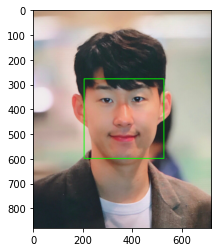

In [6]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

찾은 얼굴을 화면으로 출력한다.

dlib detector 는 dlib.rectangles 타입의 객체를 반환한다. dlib.rectangles 는 dlib.rectangle 객체의 배열 형태로 이루어져 있다.
dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함하고 있다.

스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요하다. 
이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 한다. 
face landmark는 detection의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용한다.

<Object keypoint estimation 알고리즘>

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 한다.
keypoint를 찾는 알고리즘은 크게 2가지로 나누어 진다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

Dlib landmark localization

잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾는다.

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("완료")

완료


저장한 landmark 모델을 불러온다.
landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환한다.

In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


points는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있다.
조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었다.
따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 된다.
이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장된다.

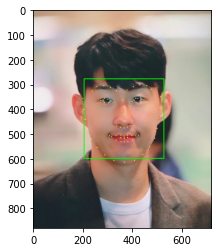

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴 랜드마크가 이미지에 출력된다.

Step 3. 스티커 적용 위치 확인하기

In [11]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코의 index는 30이지만 33으로 수정
    x = landmark[33][0]
    y = landmark[33][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(366, 475)
(x,y) : (366,314)
(w,h) : (322,322)


좌표를 확인해보니 얼굴 이미지에서의 코의 중심점이 (366, 475)이다.

Step 4. 스티커 적용하기

(322, 322, 3)


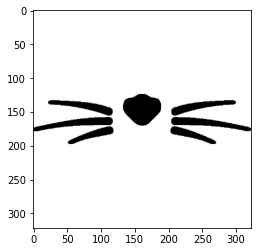

In [12]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

고양이 수염 이미지를 읽고 윗 단계에서 계산한 크기로 resize한다.

In [15]:
refined_x = x - w // 2
refined_y = y - h // 16
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (205,294)


원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정한다. 이미지 시작점은 top-left 좌표이기 때문이다.

In [18]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("완료~")

완료~


원본 이미지에 스티커를 적용한다.

스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용한다. 따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하시면 된다. img_show 에 다시 적용한다.

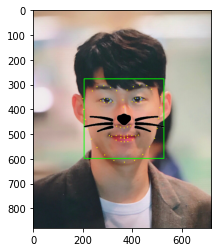

In [19]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

결과 이미지를 출력하면, 스티커 기본 기능이 완성된 것을 볼 수 잇다.

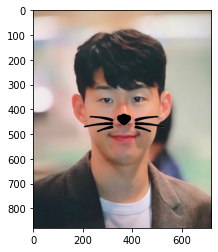

In [20]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

bounding box와 landmark를 제거하고 최종 결과만 출력해 보니 깔끔하게 스티커가 적용된 사진을 볼 수 있다.(img_show 대신, img_bgr을 활용한 것이다.)

Step 5. 문제점 찾아보기

1. 각도가 바뀌어도 스티커가 제대로 적용이 될까?

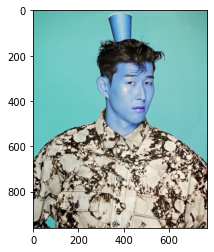

In [21]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/son2.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

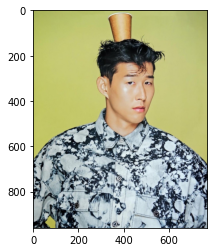

In [22]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [23]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
print("완료")

완료


In [24]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("완료")

완료


rectangles[[(340, 242) (563, 464)]]


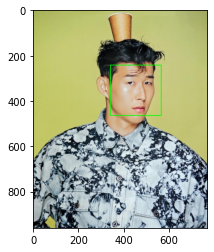

In [25]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [26]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("완료")

완료


In [27]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


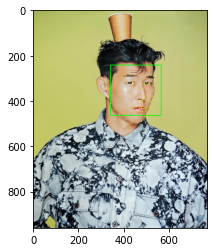

In [28]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [29]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코의 index는 30이지만 33으로 수정
    x = landmark[33][0]
    y = landmark[33][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(481, 402)
(x,y) : (481,291)
(w,h) : (224,224)


(224, 224, 3)


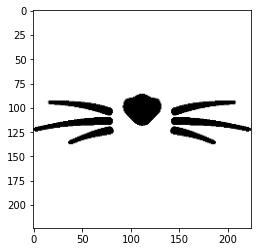

In [30]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

In [31]:
refined_x = x - w // 2
refined_y = y - h // 16
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (369,277)


In [32]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("완료~")

완료~


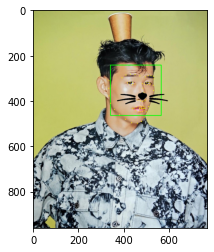

In [33]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

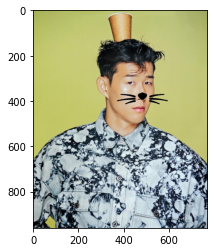

In [34]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

얼굴을 옆으로 돌린 상태에서도 얼굴의 bounding box 위치와 landmark의 위치를 정확히 찾아냈다. 또한 스티커도 정상적으로 부착됐다. 하지만 얼굴을 단순히 옆으로 돌린 것이 아니라 갸우뚱하는 상태라면 스티커도 그에 맞추어 돌려져야 한다.  

2. 각도가 바뀌고, 거리가 있어도 스티커가 제대로 적용이 될까?

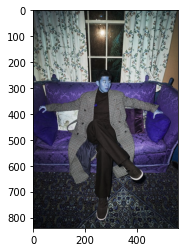

In [37]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/son3.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

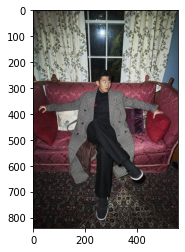

In [38]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [39]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
print("완료")

완료


In [40]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("완료")

완료


rectangles[[(256, 257) (308, 308)]]


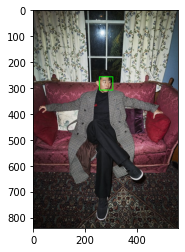

In [41]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [42]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("완료")

완료


In [43]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


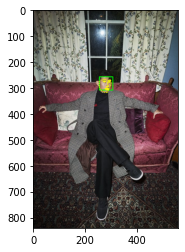

In [44]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [45]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코의 index는 30이지만 33으로 수정
    x = landmark[33][0]
    y = landmark[33][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(288, 295)
(x,y) : (288,269)
(w,h) : (53,53)


(53, 53, 3)


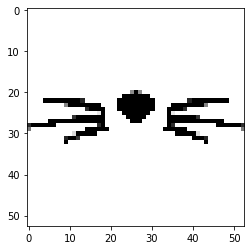

In [46]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

In [47]:
refined_x = x - w // 2
refined_y = y - h // 16
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (262,266)


In [48]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("완료~")

완료~


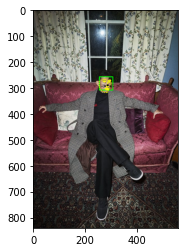

In [49]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

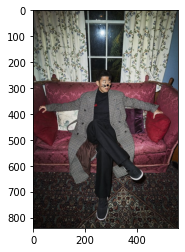

In [50]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

얼굴을 옆으로 돌린 상태에서도 얼굴의 bounding box 위치와 landmark의 위치를 정확히 찾아냈다. 스티커 역시 잘 부착됐다. 물론 피사체가 작아졌기 때문에 정상적으로 구동이 되지 않을 수도 있었는데 이상없이 부착됐다.

EXPLORATION 3 회고

EXPLORATION 3를 해보니 재미있었으면서도 어려웠다고 느껴진다. 재미있다고 느낀 이유는 이미지를 통해 코드가 잘 구동되고 있는지 확인이 되어서이다. bounding box 위치와 landmark의 위치가 시각적으로 표현되니 과정이 매끄럽다고 느껴질 수 밖에 없었고, 스티커가 최종적으로 잘 부착된 걸 보면서 결과도 만족스러웠다. 어렵다고 느낀 이유는 역시 계산이다. 원본 이미지에 스티커 이미지를 부착하기 위해 x, y의 좌표를 수정하는데 애먹었다. 이 부분에 시간을 가장 많이 할애했다. EXPLORATION 3를 하면서 알아가는 것은 사진을 사용할 때는 무조건 깨끗한 사진을 이용해야 인식률이 높아진다는 것이고, 피사체가 어느 정도 멀어졌을 때는 스티커가 부착이 되지만 일정 이상 멀어지면 인식조차 못할 수도 있다는 것이다. 또한 밝기 조절에 실패할 경우에는 얼굴인식이 세세하게 되지 않아 landmark가 원하는 곳에 생성이 될 수 없다는 것이다. 아직 시도해 보지 않은 것이 피사체가 여러개일 경우의 스티커 부착 여부다. 실제로 어플을 사용했을때 4명까지 인식이 되는 것을 보았는데 한 번 시도해 볼 필요가 있겠다. 마지막으로 실행속도가 중요한 것인지 생각해보면, 인식을 하는 시간을 고려했을 때 크게 중요하지 않다고 본다. 적당한 속도와 높은 정확성을 가진 스티커앱이 좋은 스티커앱이다.